# Create Elevation Index

Copernicus 30m DEM on [AWS open data](https://copernicus-dem-30m.s3.amazonaws.com/readme.html) does not have a spatial index of the available tiles. We need to generate one, joining it to the spatial index provided. The polygon index can then be used to query for scenes matching an analysis aoi.


1. Download the index shapefile provided by copernicus
2. Table join index vectors with list of available files on s3
3. Save joined index
4. Create visual to determine data availability


In [87]:
import boto3
import geopandas as gpd
import os
import pandas as pd

index_dir = "/projects/maap-users/alexdevseed/"
index_zip = "/".join(["zip:/", index_dir, "grid.zip"])
index_shp = os.path.join(index_dir, "dem30mGrid.json")
clean_index_geojson =  os.path.join(index_dir, "dem30m_tiles.geojson")

In [9]:
#https://copernicus-dem-30m.s3.amazonaws.com/grid.zip
# save as cop_dem_30m.zip
!wget https://copernicus-dem-30m.s3.amazonaws.com/grid.zip -O $index_zip
#!unzip -d $index_dir $index_zip # geopandas can read inside a zip

--2021-03-29 22:36:39--  https://copernicus-dem-30m.s3.amazonaws.com/grid.zip
Resolving copernicus-dem-30m.s3.amazonaws.com (copernicus-dem-30m.s3.amazonaws.com)... 52.219.72.18
Connecting to copernicus-dem-30m.s3.amazonaws.com (copernicus-dem-30m.s3.amazonaws.com)|52.219.72.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2244913 (2.1M) [application/x-zip-compressed]
Saving to: ‘/projects/maap-users/alexdevseed/grid.zip’

/projects/maap-user 100%[===================>]   2.14M  3.38MB/s    in 0.6s    

2021-03-29 22:36:40 (3.38 MB/s) - ‘/projects/maap-users/alexdevseed/grid.zip’ saved [2244913/2244913]

Archive:  /projects/maap-users/alexdevseed/grid.zip
  inflating: /projects/maap-users/alexdevseed/dem30mGrid.dbf  
  inflating: /projects/maap-users/alexdevseed/dem30mGrid.json  
  inflating: /projects/maap-users/alexdevseed/dem30mGrid.prj  
  inflating: /projects/maap-users/alexdevseed/dem30mGrid.shp  
  inflating: /projects/maap-users/alexdevseed/dem30mGrid

In [86]:
dem_30m_index = gpd.read_file(index_zip)
print(dem_30m_index.shape)
dem_30m_index.head()

(64800, 2)


,id,geometry
0,Copernicus_DSM_COG_10_N85_00_W180_00_DEM,"POLYGON ((-180.001 85.000, -180.001 86.000, -1..."
1,Copernicus_DSM_COG_10_N85_00_W179_00_DEM,"POLYGON ((-179.001 85.000, -179.001 86.000, -1..."
2,Copernicus_DSM_COG_10_N85_00_W178_00_DEM,"POLYGON ((-178.001 85.000, -178.001 86.000, -1..."
3,Copernicus_DSM_COG_10_N85_00_W177_00_DEM,"POLYGON ((-177.001 85.000, -177.001 86.000, -1..."
4,Copernicus_DSM_COG_10_N85_00_W176_00_DEM,"POLYGON ((-176.001 85.000, -176.001 86.000, -1..."


In [16]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('copernicus-dem-30m')
bucket_files = [s3_file.key for s3_file in bucket.objects.all()]

In [59]:

bf_df = pd.DataFrame(bucket_files, columns=["key"])
bf_df["id"] = bf_df["key"].str.split(pat="/").str[0]
bf_df["s3"] = "s3://copernicus-dem-30m/" + bf_df["key"]
bf_df.head()

(26449, 3)


,key,id,s3
0,Copernicus_DSM_COG_10_N00_00_E006_00_DEM/Coper...,Copernicus_DSM_COG_10_N00_00_E006_00_DEM,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...
1,Copernicus_DSM_COG_10_N00_00_E009_00_DEM/Coper...,Copernicus_DSM_COG_10_N00_00_E009_00_DEM,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...
2,Copernicus_DSM_COG_10_N00_00_E010_00_DEM/Coper...,Copernicus_DSM_COG_10_N00_00_E010_00_DEM,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...
3,Copernicus_DSM_COG_10_N00_00_E011_00_DEM/Coper...,Copernicus_DSM_COG_10_N00_00_E011_00_DEM,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...
4,Copernicus_DSM_COG_10_N00_00_E012_00_DEM/Coper...,Copernicus_DSM_COG_10_N00_00_E012_00_DEM,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...


In [55]:
dem_30m_index_new = dem_30m_index.merge(bf_df, on="id")

In [98]:
dem_30m_index_new.to_file(clean_index_geojson, driver="GeoJSON")

<AxesSubplot:>

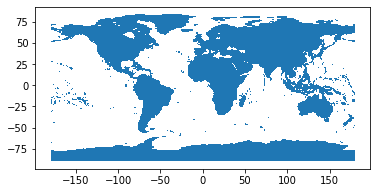

In [88]:
dem_30m_index_new.plot()

## Error Checking

Looks pretty good with one small problem, the number of final tiles is not the same as the total number of files in s3. So we need to find the missing files and figure out what they are.

In [89]:
# Compare the number of S3 files to the number of Tiles after inner join
bf_df.shape[0]-dem_30m_index_new.shape[0]
# 4 files did not match the index shp? Redo with right join to find which?

4

In [97]:
# Do a right join, then select the records with no match
# Or just do an search for id's not in the original json
bf_df[~bf_df["id"].isin(dem_30m_index["id"])]
#great none of those are actual tiles

,key,id,s3
26445,geometry.txt,geometry.txt,s3://copernicus-dem-30m/geometry.txt
26446,grid.zip,grid.zip,s3://copernicus-dem-30m/grid.zip
26447,readme.html,readme.html,s3://copernicus-dem-30m/readme.html
26448,tileList.txt,tileList.txt,s3://copernicus-dem-30m/tileList.txt
